In [52]:
import jax
import jax.numpy as jnp

from flax import linen as nn
from flax.training import train_state

import optax

import matplotlib.pyplot as plt

from jax_tutorial.dynamics import dynamics_fn, simple_controller, num_state_dims

## JAX Introduction-by-Example: optimal control

Let's learn some JAX by example. We'll consider the dynamics of a satellite rendezvous in low-Earth orbit; I've already implemented the dynamics and a basic controller for you, so we can dive right in.

Let's look at what the dynamics of this system are like by simulating some trajectories, and we'll see how JAX can accelerate this process. We'll start by writing a simulator as you would usually write one, by looping over timesteps and integrating the dynamics.

CPU times: user 6.24 s, sys: 0 ns, total: 6.24 s
Wall time: 6.23 s


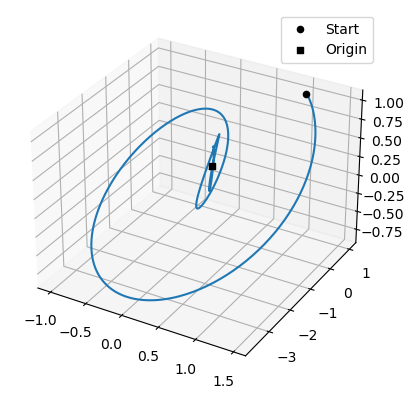

In [65]:
# Let's simulate some trajectories
def closed_loop_dynamics_fn(x):
    u = simple_controller(x)
    return dynamics_fn(x, u)

def simulate(dynamics_fn, x_init):
    T = 1000
    dt = 0.2
    xs = jnp.zeros((T, x_init.shape[0]))
    xs = xs.at[0, :].set(x_init)
    
    for t in range(1, T):
        x_current = xs[t - 1, :]
        dxdt = dynamics_fn(x_current)
        x_next = x_current + dt * dxdt
        xs = xs.at[t, :].set(x_next)
    
    return xs

%time xs = simulate(closed_loop_dynamics_fn, jnp.array([1.0, 1.0, 1.0, 0.0, 0.0, 0.0]))
ax = plt.axes(projection="3d")
ax.plot(xs[:, 0], xs[:, 1], xs[:, 2])
ax.scatter(xs[0, 0], xs[0, 1], xs[0, 2], marker="o", color="k", label="Start")
ax.scatter(0, 0, 0, marker="s", color="k", label="Origin")
ax.legend()

We see that it took about 6 seconds to simulate this trajectory. That's not great, especially if we expect to run this code a lot over the course of a research project.

This is the place where JAX can have it's first big impact: speeding up your numerical Python code! JAX has a feature called JIT (just-in-time compilation) that compiles your code to XLA (for more details, see the [JAX tutorials](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html)). Let's see how that speeds up our simulator!

CPU times: user 1.21 s, sys: 3.96 ms, total: 1.21 s
Wall time: 1.21 s


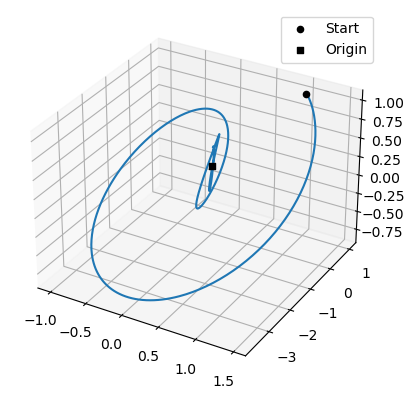

In [48]:
# Seems pretty easy, right?
compiled_dynamics_fn = jax.jit(closed_loop_dynamics_fn)

%time xs = simulate(compiled_dynamics_fn, jnp.array([1.0, 1.0, 1.0, 0.0, 0.0, 0.0]))
ax = plt.axes(projection="3d")
ax.plot(xs[:, 0], xs[:, 1], xs[:, 2])
ax.scatter(xs[0, 0], xs[0, 1], xs[0, 2], marker="o", color="k", label="Start")
ax.scatter(0, 0, 0, marker="s", color="k", label="Origin")
ax.legend()

Much better, right? And this is only the start! We can also use JAX to auto-vectorize our functions. We wrote the dynamics function and controller to work with a single state/control pair at a time, but vectorizing is easy with JAX! In fact, we can vectorize our entire simulator!!!

CPU times: user 4.24 s, sys: 35 µs, total: 4.24 s
Wall time: 4.23 s


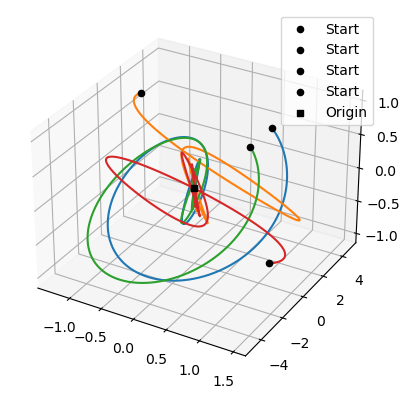

In [49]:
simulate_batch = jax.vmap(simulate, in_axes=(None, 0))

x_inits = jnp.array([
    [1.0, 1.0, 1.0, 0.0, 0.0, 0.0],
    [-1.0, 1.0, 1.0, 0.0, 0.0, 0.0],
    [1.0, -1.0, 1.0, 0.0, 0.0, 0.0],
    [1.0, 1.0, -1.0, 0.0, 0.0, 0.0],
])
%time xs = simulate_batch(compiled_dynamics_fn, x_inits)
ax = plt.axes(projection="3d")
for i in range(xs.shape[0]):
    ax.plot(xs[i, :, 0], xs[i, :, 1], xs[i, :, 2])
    ax.scatter(xs[i, 0, 0], xs[i, 0, 1], xs[i, 0, 2], marker="o", color="k", label="Start")
ax.scatter(0, 0, 0, marker="s", color="k", label="Origin")
ax.legend()

We can actually do one better by using the XLA-specific looping constructs for our simulator.

CPU times: user 144 ms, sys: 2 µs, total: 144 ms
Wall time: 143 ms


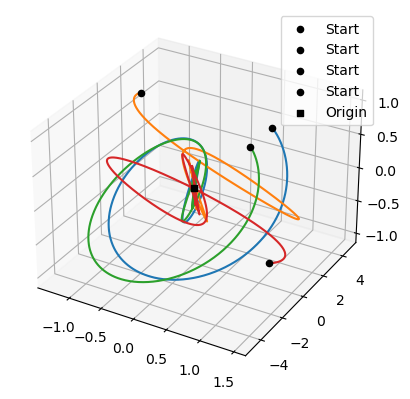

In [50]:
# A special form required by the scan construct
def simulate_step(x_current, dummy_input):
    dt = 0.1
    dxdt = compiled_dynamics_fn(x_current)
    x_next = x_current + dt * dxdt
    return x_next, x_next

T = 2000
simulate_xla = lambda x_init: jax.lax.scan(simulate_step, x_init, xs=None, length=T)[1]
simulate_xla_batched = jax.jit(jax.vmap(simulate_xla))

%time xs = simulate_xla_batched(x_inits)
ax = plt.axes(projection="3d")
for i in range(xs.shape[0]):
    ax.plot(xs[i, :, 0], xs[i, :, 1], xs[i, :, 2])
    ax.scatter(xs[i, 0, 0], xs[i, 0, 1], xs[i, 0, 2], marker="o", color="k", label="Start")
ax.scatter(0, 0, 0, marker="s", color="k", label="Origin")
ax.legend()

CPU times: user 108 ms, sys: 16 ms, total: 124 ms
Wall time: 120 ms


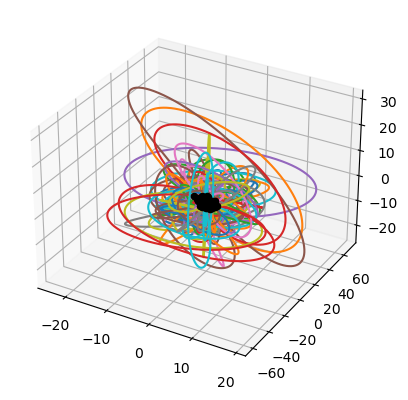

In [51]:
# How far can we push this?
N = 100
prng_key = jax.random.PRNGKey(0)
x_inits = jax.random.normal(prng_key, shape=(N, 6))

%time xs = simulate_xla_batched(x_inits)

ax = plt.axes(projection="3d")
for i in range(xs.shape[0]):
    ax.plot(xs[i, :, 0], xs[i, :, 1], xs[i, :, 2])
    ax.scatter(xs[i, 0, 0], xs[i, 0, 1], xs[i, 0, 2], marker="o", color="k", label="Start")
ax.scatter(0, 0, 0, marker="s", color="k", label="Origin")

## Beyond speedups

This is just scratching the surface of JAX. The ability to easily speed code that is almost vanilla Numpy up by 100x is nice, but we can do more than just speed up your code. Autodiff is a really powerful function of JAX as well!

To see how this plays out, let's try to train a neural network controller to orbit the origin (rather than going straight there).

In [89]:
# First let's define a simple neural network controller using Flax, a JAX-based neural network library
class Policy(nn.Module):
    @nn.compact
    def __call__(self, x):
        # Policy has 3 hidden layers
        u = nn.Dense(features=32)(x)
        u = nn.tanh(u)
        u = nn.Dense(features=32)(u)
        u = nn.tanh(u)
        u = nn.Dense(features=32)(u)
        u = nn.tanh(u)
        u = nn.Dense(features=3)(u)
        
        # Add the LQR controller
        u_lqr = simple_controller(x)

        return u + u_lqr
    
# The loss function simulates the trajectory with the given policy and tries to make
# the distance of the origin close to 0.5 meters over the last 500 steps of the trajectory
@jax.jit
def train_step(training_state, xs):
    """Train for a single step"""

    def loss_fn(params):
        # Simulate for 2000 steps with the given controller
        def simulate_step(x_current, dummy_input):
            dt = 0.1
            u = Policy().apply({"params": params}, x_current).squeeze()
            dxdt = dynamics_fn(x_current, u)
            x_next = x_current + dt * dxdt
            return x_next, x_next

        T = 2000
        simulate_xla = lambda x_init: jax.lax.scan(simulate_step, x_init, xs=None, length=T)[1]
        simulate_xla_batched = jax.vmap(simulate_xla)
        x_trajectory = simulate_xla_batched(xs)
        distance_to_origin = jnp.linalg.norm(x_trajectory[:, -500:, :4], axis=-1)
        
        loss = ((distance_to_origin - 0.5) ** 2).mean()

        return loss

    # Get the gradient of the loss and step the optimizer
    loss, grads = jax.value_and_grad(loss_fn)(training_state.params)
    training_state = training_state.apply_gradients(grads=grads)

    return training_state, loss

def train_epoch(training_state, states, batch_size, epoch, rng):
    """Train for a single epoch."""
    num_samples = states.shape[0]
    steps_per_epoch = num_samples // batch_size

    perms = jax.random.permutation(rng, num_samples)
    perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    batch_losses = []
    for perm in perms:
        training_state, loss = train_step(
            training_state,
            states[perm],
        )
        batch_losses.append(loss)
    
    print(f"Epoch {epoch}, loss: {jnp.array(batch_losses).mean()}")

    return training_state

# Run training
rng = jax.random.PRNGKey(0)

# Hyperparams
batch_size = 256
num_samples = batch_size * 10
learning_rate = 1e-2
momentum = 0.0
num_epochs = 10

# Make a dataset
rng, subkey = jax.random.split(rng)
states = 2 * jax.random.normal(subkey, shape=(num_samples, 6))

# Initialize the training state
rng, subkey = jax.random.split(rng)
policy = Policy()
params = policy.init(subkey, jnp.ones((6,)))["params"]
tx = optax.sgd(learning_rate, momentum)
training_state = train_state.TrainState.create(apply_fn=policy.apply, params=params, tx=tx)

for epoch in range(1, num_epochs + 1):
    # Use a separate PRNG key to permute image data during shuffling
    rng, subkey = jax.random.split(rng)
    # Run an optimization step over a training batch
    training_state = train_epoch(
        training_state, states, batch_size, epoch, subkey
    )

Epoch 1, loss: 15.00567626953125
Epoch 2, loss: 12.082429885864258
Epoch 3, loss: 9.7989501953125
Epoch 4, loss: 6.585372447967529
Epoch 5, loss: 3.531914472579956
Epoch 6, loss: 1.852929711341858
Epoch 7, loss: 1.1459016799926758
Epoch 8, loss: 0.8079453706741333
Epoch 9, loss: 0.6178131103515625
Epoch 10, loss: 0.4987489879131317


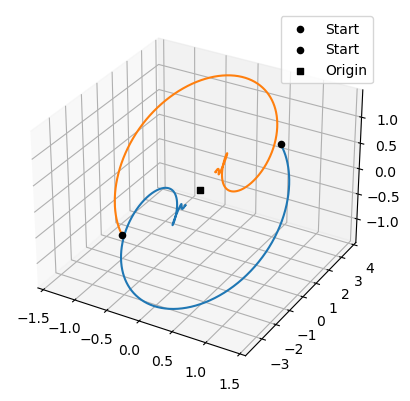

In [90]:
# Let's see how it worked!
params = training_state.params
def simulate_step_learned_policy(x_current, dummy_input):
    dt = 0.1
    u = Policy().apply({"params": params}, x_current).squeeze()
    dxdt = dynamics_fn(x_current, u)
    x_next = x_current + dt * dxdt
    return x_next, x_next

T = 2000
simulate_xla = lambda x_init: jax.lax.scan(simulate_step_learned_policy, x_init, xs=None, length=T)[1]
simulate_xla_batched = jax.jit(jax.vmap(simulate_xla))

xs = simulate_xla_batched(jnp.array([
    [1.0, 1.0, 1.0, 0.0, 0.0, 0.0],
    [-1.0, -1.0, -1.0, 0.0, 0.0, 0.0]
]))
ax = plt.axes(projection="3d")
for i in range(xs.shape[0]):
    ax.plot(xs[i, :, 0], xs[i, :, 1], xs[i, :, 2])
    ax.scatter(xs[i, 0, 0], xs[i, 0, 1], xs[i, 0, 2], marker="o", color="k", label="Start")
ax.scatter(0, 0, 0, marker="s", color="k", label="Origin")
ax.legend()